In [1]:
!pip install tf_keras

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tf_keras as keras
from tensorflow.keras.preprocessing import image

# 1. Hàm tiền xử lý ảnh (giống hệt quá trình train/eval)
def preprocess_one_image(img_path, target_size=(112, 112)):
    if not os.path.exists(img_path):
        print(f"Không tìm thấy ảnh: {img_path}")
        return None, None
    
    # Đọc ảnh bằng OpenCV
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Chuyển sang RGB để hiển thị đúng màu
    
    # Resize về 112x112
    img_resized = cv2.resize(img_rgb, target_size)
    
    # Chuẩn hóa (Normalize) giống như lúc load dữ liệu train/eval
    # Công thức: (img - 127.5) / 128.0  -> đưa về khoảng [-1, 1]
    img_tensor = (img_resized.astype(np.float32) - 127.5) / 128.0
    
    # Thêm chiều batch: (112, 112, 3) -> (1, 112, 112, 3)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    return img_rgb, img_tensor

 
import tensorflow as tf # Thêm thư viện tf để dùng hàm l2_normalize

# ... các phần khác giữ nguyên ...

# 2. Hàm so sánh 2 ảnh (ĐÃ SỬA ĐỂ HẾT CẢNH BÁO)
def verify_two_images(model, img_path1, img_path2, threshold=0.174):
    # Tiền xử lý
    disp_img1, tensor1 = preprocess_one_image(img_path1)
    disp_img2, tensor2 = preprocess_one_image(img_path2)
    
    if tensor1 is None or tensor2 is None:
        return

    # THAY THẾ model.predict BẰNG CÁCH GỌI TRỰC TIẾP
    # training=False giúp tránh lỗi retracing và chạy nhanh hơn
    emb1 = model(tensor1, training=False)
    emb2 = model(tensor2, training=False)
    
    # CHUẨN HÓA L2 (Dùng TensorFlow để tối ưu tốc độ)
    emb1 = tf.nn.l2_normalize(emb1, axis=1)
    emb2 = tf.nn.l2_normalize(emb2, axis=1)
    
    # Tính Cosine Similarity bằng tích vô hướng (dot product)
    # Vì đã chuẩn hóa L2, tích vô hướng chính là Cosine Similarity
    similarity = tf.reduce_sum(tf.multiply(emb1, emb2), axis=1).numpy()[0]
    
    # Kết luận
    is_same = similarity > threshold
    result_text = "SAME PERSON" if is_same else "DIFFERENT PEOPLE"
    
    print(f"Cosine Similarity: {similarity:.4f}")
    print(f"Threshold: {threshold}")
    print(f"Result: {result_text}")

    # --- Hiển thị ảnh ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(disp_img1); plt.title("Image 1"); plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(disp_img2); plt.title(f"Sim: {similarity:.4f}\n{result_text}"); plt.axis('off')
    plt.show()


--- Đang kiểm tra hai ảnh được chỉ định ---
Cosine Similarity: -0.0042
Threshold: 0.174
Result: DIFFERENT PEOPLE


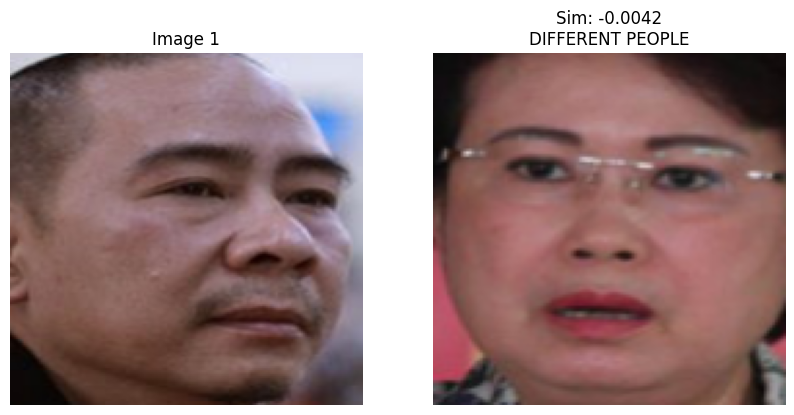

In [ ]:
import os
# 1. Định nghĩa đường dẫn ảnh
img_path1 = "/kaggle/input/vn-celeb/VN-celeb/10/1.png"
img_path2 = "/kaggle/input/vn-celeb/VN-celeb/100/0.png"
img_path3 = "/kaggle/input/vn-celeb/VN-celeb/1007/0.png"
model_path = "/kaggle/input/ghostfacenet-v1/keras/default/1/ghostfacenet_asian_adaface_backbone.keras"
# 2. Load model (nếu trước đó bạn chưa load)
backbone1 = keras.models.load_model(model_path, compile=False)

# 3. Chạy hàm verify (Sử dụng hàm verify_two_images tôi đã cung cấp ở trên)
print("--- Đang kiểm tra hai ảnh được chỉ định ---")
verify_two_images(backbone1, img_path2, img_path3, threshold=0.174)